# Here I will show how you can use Plumed built in CV module to implement the middle latent space of an Autoencoder network as a collective variable!

[Plumed](plumed.github.io) is a powerful library used for running enhanced sampling simulations. It implements an very robust Collective variable module. Here I will show that you can implement a 3-layered neural network inside Plumed using its built in functions. This is possible because simpler networks are a series of linear/affine transforms 
$$y= W^Tx +b$$
plus non-linear layers(sigmoid here) 
$$\sigma(x) = \frac{1}{1+e^{-x}} $$

Both of these operations can be evaluated using the matheval library inside Plumed (skip to the end if you want the actual code)

In [1]:
import sys,os
from glob import glob
import numpy as np
import mdtraj as md
from msmbuilder.featurizer import DihedralFeaturizer
%pylab inline
from matplotlib import pyplot as plt
import pandas as pd
import msmbuilder.utils as msmutils
import seaborn as sns
sns.set(style='white', palette='colorblind')
sns.set_context('talk',1.3)

sys.path.insert(0, "helper_func")
%load_ext autoreload
%autoreload 2


#load features

feature_files=glob('data/scaled_feats/*.jl')
tica_data=msmutils.load('data/tica_data.pkl')


features=[]
tica_data_concat=[]
for f in tica_data.keys():
    tica_data_concat.append(tica_data[f])
    features.append(msmutils.load('data/scaled_feats/'+f))
    
features=np.concatenate(features,axis=0)
tica_data_concat=np.concatenate(tica_data_concat,axis=0)

Populating the interactive namespace from numpy and matplotlib


/Users/hannah/miniconda3/envs/msmb/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/hannah/miniconda3/envs/msmb/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


#  Now begins the fun neural network part. Lets start by desiging a 3 layer autoencoder with a sigmoid non-linearity 

An autoencoder neural network is an unsupervised learning algorithm that tries to learn a latent space for its input. 
This is done by setting the output to the input. Thus the network tries to learn an identity function. 


We can now use this information, and restrict the middle layers of the encoding network to a singular value to learn the most salient features of the data. More importantly, we can use enhance sampling techniques such as metadynamics on this hidden layer to more efficiently sample alanine dipeptide. 

In [30]:
feature_files

['data/scaled_feats/CLN025-0-protein-000.jl',
 'data/scaled_feats/CLN025-0-protein-001.jl',
 'data/scaled_feats/CLN025-0-protein-002.jl',
 'data/scaled_feats/CLN025-0-protein-003.jl',
 'data/scaled_feats/CLN025-0-protein-004.jl',
 'data/scaled_feats/CLN025-0-protein-005.jl',
 'data/scaled_feats/CLN025-0-protein-006.jl',
 'data/scaled_feats/CLN025-0-protein-007.jl',
 'data/scaled_feats/CLN025-0-protein-008.jl',
 'data/scaled_feats/CLN025-0-protein-009.jl',
 'data/scaled_feats/CLN025-0-protein-010.jl',
 'data/scaled_feats/CLN025-0-protein-011.jl',
 'data/scaled_feats/CLN025-0-protein-012.jl',
 'data/scaled_feats/CLN025-0-protein-013.jl',
 'data/scaled_feats/CLN025-0-protein-014.jl',
 'data/scaled_feats/CLN025-0-protein-015.jl',
 'data/scaled_feats/CLN025-0-protein-016.jl',
 'data/scaled_feats/CLN025-0-protein-017.jl',
 'data/scaled_feats/CLN025-0-protein-018.jl',
 'data/scaled_feats/CLN025-0-protein-019.jl',
 'data/scaled_feats/CLN025-0-protein-020.jl',
 'data/scaled_feats/CLN025-0-prote

In [4]:
import torch
import numpy as np
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

from torch import optim

# Hyper Parameters 
input_size = 14
# The output class becomes our Plumed collective variable(CV)
num_classes = 1


class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        #self.df = df 
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_classes = num_classes

        self.l1 = nn.Linear(input_size, hidden_size) 
        self.l2 = nn.Sigmoid()
        self.l3 = nn.Linear(hidden_size, num_classes)     
    
    def forward(self, x):
        out = self.l1(x)
        out = self.l2(out)
        out = self.l3(out)
        return out
    
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.l1 = nn.Linear(num_classes, hidden_size)
        self.l2 = nn.Sigmoid()
        self.l3 = nn.Linear(hidden_size, input_size)
        
    def forward(self, x):
        out = self.l1(x)
        out = self.l2(out)
        out = self.l3(out)
        return out
    
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.fc1 = Encoder()
        self.fc2 = Decoder()

    def forward(self, x):
        return self.fc2(self.fc1(x)) 
    
class BatchSampler(object):
    """Wraps another sampler to yield a mini-batch of indices.
    Args:
        sampler (Sampler): Base sampler.
        batch_size (int): Size of mini-batch.
        drop_last (bool): If ``True``, the sampler will drop the last batch if
            its size would be less than ``batch_size``
    Example:
        >>> list(BatchSampler(range(10), batch_size=3, drop_last=False))
        [[0, 1, 2], [3, 4, 5], [6, 7, 8], [9]]
        >>> list(BatchSampler(range(10), batch_size=3, drop_last=True))
        [[0, 1, 2], [3, 4, 5], [6, 7, 8]]
    """

    def __init__(self, sampler, batch_size, drop_last):
        self.sampler = sampler
        self.batch_size = batch_size
        self.drop_last = drop_last

    def __iter__(self):
        batch = []
        for idx in self.sampler:
            batch.append(idx)
            if len(batch) == self.batch_size:
                yield batch
                batch = []
        if len(batch) > 0 and not self.drop_last:
            yield batch

    def __len__(self):
        if self.drop_last:
            return len(self.sampler) // self.batch_size
        else:
            return (len(self.sampler) + self.batch_size - 1) // self.batch_size

In [20]:
# if os.path.isfile("./autoencoder.net"):
#     model = torch.load("./autoencoder.net")
# else:
model = AutoEncoder()    

# Train our autoencoder

In [21]:
losses=[]
#hidden_size_trials=[1,2,5,8,10,12,20,50,100]
hidden_size_trials=[2]
for hidden in hidden_size_trials:
    hidden_size=hidden

    model=AutoEncoder()
    all_x = Variable(torch.from_numpy(features))
    rnd_sampler = BatchSampler(features[::10], batch_size=500,drop_last=False)
    loss = nn.MSELoss()

    optimizer = optim.Adam(model.parameters(), lr=0.5)
    loss_list=[]
    epoch_losses=[]
    for epoch in range(10):
        for i in rnd_sampler:
            optimizer.zero_grad()

            x = Variable(torch.from_numpy(np.vstack(i[:-1])))
            x_tau = Variable(torch.from_numpy(np.vstack(i[1:])))
            y=model(x)
            output = loss(y,x_tau) 
            output.backward()
            loss_list.extend(output.data.tolist())
            optimizer.step()
        epoch_losses.append(loss_list[-1])
    losses.append(epoch_losses)


In [29]:
# Our auto-encoder is able learn the space rather well after only a epochs. 

IndexError: list index out of range

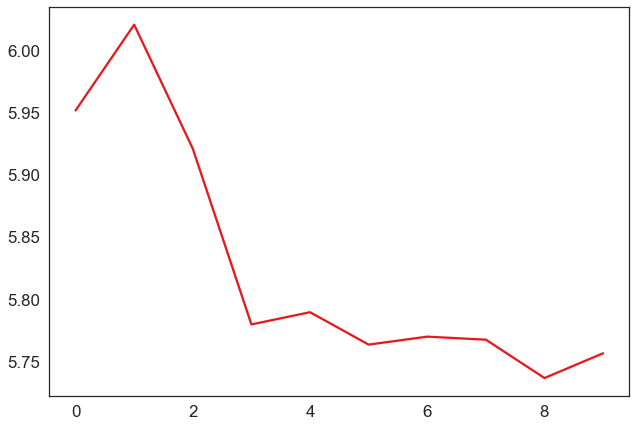

In [22]:
sns.set_palette('Set1',n_colors=9)
for x in range(5):
    plot(losses[x],label=hidden_size_trials[x])
legend()

In [23]:
new_y = model.fc1.forward(all_x)

In [24]:
new_y_dat=new_y.data.tolist()[::10]

# For example our original trajectory has 2 transitions that show as high values in the auto-encoder's middle layer

KeyboardInterrupt: 

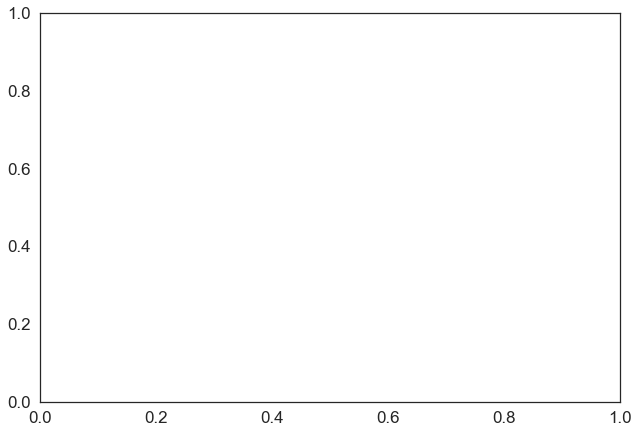

In [29]:
from matplotlib.colors import LogNorm
hist(new_y_dat,bins=100,norm=LogNorm())


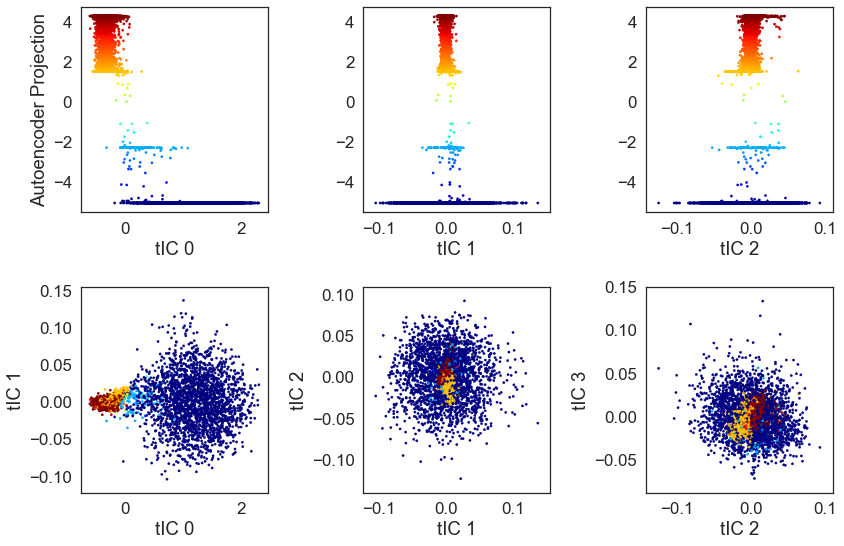

In [26]:
#cb = plt.colorbar()
figure(figsize=(12,8))
for k in range(3):
    
    subplot(2,3,k+1)
    xlabel('tIC '+str(k))
    if k==0:
        ylabel('Autoencoder Projection')
    scatter(tica_data_concat[:,k][::10],new_y.data.tolist()[::10],c=new_y.data.tolist()[::10],cmap='jet',s=5)

    subplot(2,3,k+1+3)
    xlabel('tIC '+str(k))
    ylabel('tIC '+str(k+1))
    scatter(tica_data_concat[:,k][::10],tica_data_concat[:,k+1][::10],c=new_y.data.tolist()[::10],cmap='jet',s=5)

tight_layout()
#cb.set_label("Neural Network Projection")
savefig('nn_projection.png',format='png',dpi=300)
#savefig('nn_projection_2dtics.pdf',format='pdf',dpi=300)

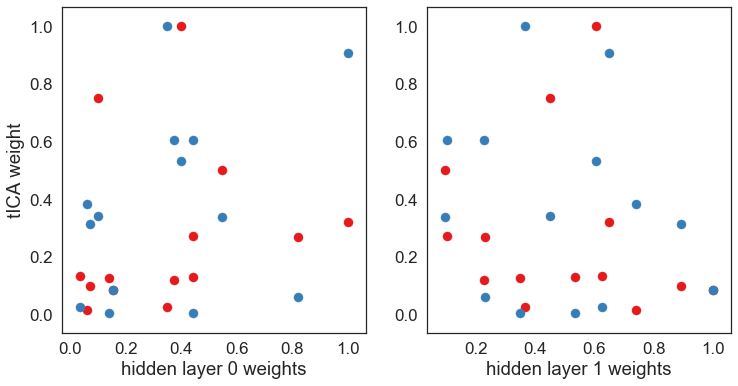

In [27]:
tica_mdl=msmutils.load('data/tica_mdl.pkl')


def norm_plot(x):
    plot(np.abs(x)/np.max(np.abs(x)))

def norm_scatter(x,y):
    scatter(np.abs(x)/np.max(np.abs(x)),np.abs(y)/np.max(np.abs(y)))

figure(figsize=(12,6))
    
subplot(1,2,1)
norm_scatter(model.fc1.l1.weight.data.numpy()[0],tica_mdl.components_[0])
norm_scatter(model.fc1.l1.weight.data.numpy()[0],tica_mdl.components_[1])
xlabel('hidden layer 0 weights')
ylabel('tICA weight')
#plot([[0,0],[1,1]])

subplot(1,2,2)
norm_scatter(model.fc1.l1.weight.data.numpy()[1],tica_mdl.components_[0])
norm_scatter(model.fc1.l1.weight.data.numpy()[1],tica_mdl.components_[1])
xlabel('hidden layer 1 weights')

#plot([[0,0],[1,1]])


In [ ]:
from matplotlib.colors import LogNorm
hist2d(tica_data_concat[:,0],tica_data_concat[:,1],bins=100,norm=LogNorm())
show()

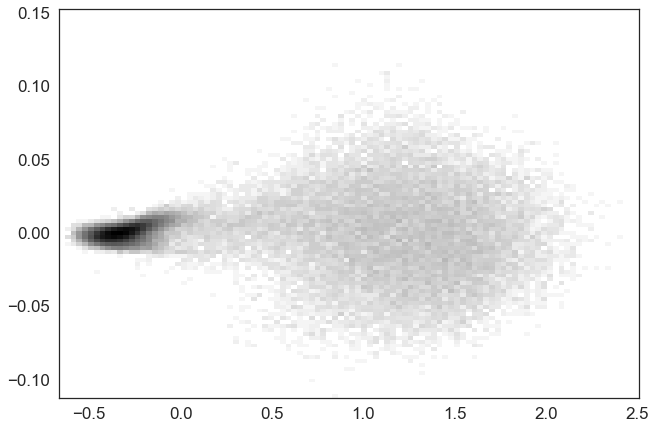

In [28]:
from matplotlib.colors import LogNorm
hist2d(tica_data_concat[:,0],tica_data_concat[:,1],bins=100,norm=LogNorm())
show()

In [203]:
feat_descr=msmutils.load('feature_descriptor.h5')

In [204]:
feat_descr

,atominds,featuregroup,featurizer,otherinfo,resids,resnames,resseqs
0,"[4, 25, 46, 60]",N/A,AlphaAngle,cos,"[0, 1, 2, 3]","[ASP, PRO, TYR]","[1, 2, 3, 4]"
1,"[25, 46, 60, 72]",N/A,AlphaAngle,cos,"[1, 2, 3, 4]","[ASP, GLU, PRO, TYR]","[2, 3, 4, 5]"
2,"[46, 60, 72, 87]",N/A,AlphaAngle,cos,"[2, 3, 4, 5]","[ASP, GLU, PRO, THR]","[3, 4, 5, 6]"
3,"[60, 72, 87, 101]",N/A,AlphaAngle,cos,"[3, 4, 5, 6]","[THR, GLU, PRO, GLY]","[4, 5, 6, 7]"
4,"[72, 87, 101, 108]",N/A,AlphaAngle,cos,"[4, 5, 6, 7]","[THR, GLU, GLY]","[8, 5, 6, 7]"
5,"[87, 101, 108, 122]",N/A,AlphaAngle,cos,"[8, 5, 6, 7]","[TRP, THR, GLY]","[8, 9, 6, 7]"
6,"[101, 108, 122, 149]",N/A,AlphaAngle,cos,"[8, 9, 6, 7]","[TRP, THR, TYR, GLY]","[8, 9, 10, 7]"
7,"[4, 25, 46, 60]",N/A,AlphaAngle,sin,"[0, 1, 2, 3]","[ASP, PRO, TYR]","[1, 2, 3, 4]"
8,"[25, 46, 60, 72]",N/A,AlphaAngle,sin,"[1, 2, 3, 4]","[ASP, GLU, PRO, TYR]","[2, 3, 4, 5]"
9,"[46, 60, 72, 87]",N/A,AlphaAngle,sin,"[2, 3, 4, 5]","[ASP, GLU, PRO, THR]","[3, 4, 5, 6]"


# Now I will show how we can use the auto-encoder's encoder network as a CV for input in Plumed 

This is done by  writiting the 3 layered encoder network into Plumed using a series of vector operations + exponential transforms. The full functions are given in the helper_func folder

In [200]:
from helper_func.helper import *

In [201]:
model.fc1.df = df

In [205]:
df

,atominds,featuregroup,featurizer,otherinfo,resids,resnames,resseqs
0,"[21, 23, 25, 42]",phi,Dihedral,sin,"[0, 1]",[TYR],"[1, 2]"
1,"[42, 44, 46, 54]",phi,Dihedral,sin,"[1, 2]","[TYR, ASP]","[2, 3]"
2,"[54, 56, 60, 68]",phi,Dihedral,sin,"[2, 3]","[PRO, ASP]","[3, 4]"
3,"[68, 70, 72, 83]",phi,Dihedral,sin,"[3, 4]","[GLU, PRO]","[4, 5]"
4,"[83, 85, 87, 97]",phi,Dihedral,sin,"[4, 5]","[GLU, THR]","[5, 6]"
5,"[97, 99, 101, 104]",phi,Dihedral,sin,"[5, 6]","[GLY, THR]","[6, 7]"
6,"[104, 106, 108, 118]",phi,Dihedral,sin,"[6, 7]","[GLY, THR]","[8, 7]"
7,"[118, 120, 122, 142]",phi,Dihedral,sin,"[8, 7]","[TRP, THR]","[8, 9]"
8,"[142, 147, 149, 144]",phi,Dihedral,sin,"[8, 9]","[TYR, TRP]","[9, 10]"
9,"[21, 23, 25, 42]",phi,Dihedral,cos,"[0, 1]",[TYR],"[1, 2]"


First the results!

In [202]:
print(render_network(model.fc1))

TORSION ATOMS=22,24,26,43 LABEL=phi_0_1 
TORSION ATOMS=43,45,47,55 LABEL=phi_1_2 
TORSION ATOMS=55,57,61,69 LABEL=phi_2_3 
TORSION ATOMS=69,71,73,84 LABEL=phi_3_4 
TORSION ATOMS=84,86,88,98 LABEL=phi_4_5 
TORSION ATOMS=98,100,102,105 LABEL=phi_5_6 
TORSION ATOMS=105,107,109,119 LABEL=phi_6_7 
TORSION ATOMS=119,121,123,143 LABEL=phi_8_7 
TORSION ATOMS=143,148,150,145 LABEL=phi_8_9 
TORSION ATOMS=1,5,22,24 LABEL=psi_0_1 
TORSION ATOMS=24,26,43,45 LABEL=psi_1_2 
TORSION ATOMS=45,47,55,57 LABEL=psi_2_3 
TORSION ATOMS=57,61,69,71 LABEL=psi_3_4 
TORSION ATOMS=71,73,84,86 LABEL=psi_4_5 
TORSION ATOMS=86,88,98,100 LABEL=psi_5_6 
TORSION ATOMS=100,102,105,107 LABEL=psi_6_7 
TORSION ATOMS=107,109,119,121 LABEL=psi_8_7 
TORSION ATOMS=121,123,143,148 LABEL=psi_8_9 
MATHEVAL ARG=phi_0_1 FUNC=sin(x) LABEL=l00 PERIODIC=NO 
MATHEVAL ARG=phi_1_2 FUNC=sin(x) LABEL=l01 PERIODIC=NO 
MATHEVAL ARG=phi_2_3 FUNC=sin(x) LABEL=l02 PERIODIC=NO 
MATHEVAL ARG=phi_3_4 FUNC=sin(x) LABEL=l03 PERIODIC=NO 
MATHEVAL ARG

# This is possible due to the modular design of computational graphs

This is possible because neural networks are highly sequential, and can be programatically written up to depend on the
outputs of their parent nodes. 

Therefore all we need to do is decide what type of layer we are on and call the appropriate function that will generate the appropriate code. Forexample, 

MATHEVAL ARG=l16 FUNC=1/(1+exp(-x)) LABEL=l26

does a sigmoid transform on the input of 6th neuron of the second layer( L-2-6 = L26). Its input is the ouput of the 6th neuron in the first layer ( L-1-6)

# To actually run Metadynamics, we need to add the following two lines at the end 



METAD ARG=l30 SIGMA=0.2 HEIGHT=1 BIASFACTOR=20 TEMP=300 FILE=HILLS PACE=1000 LABEL=metad 

PRINT ARG=l30,metad.bias STRIDE=1000 FILE=BIAS.0

The full file is given in plumed_autoencoder.dat, and can be used as regular input for sampling. 


# It is much faster to use GPUs for running simulations, so the actual simulation code is not presented it. However, they are vanilla NPT dynamics run for about 4.5ns.

# Visualizing the results

In [39]:
plumed_traj = md.load("../plumed_traj_2/trajectory.dcd",top="../plumed_traj_2/starting_coordinates/0.pdb")


In [40]:
plumed_traj_feat = DihedralFeaturizer(sincos=True).transform([plumed_traj])[0]
plumed_traj_plot_feat = DihedralFeaturizer(sincos=False).transform([plumed_traj])[0]


In [41]:
x_plumed = Variable(torch.from_numpy(plumed_traj_feat))
y_plumed = model.fc1(x_plumed)
nn_y_plumed = np.array(y_plumed.data.tolist())[:,0]


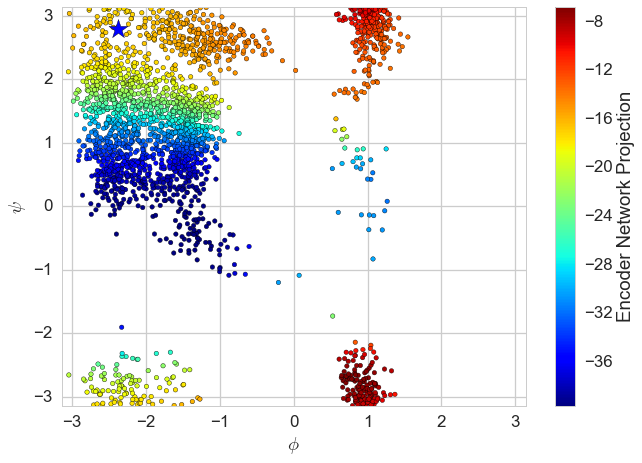

In [52]:
scatter(plumed_traj_plot_feat[0,0],plumed_traj_plot_feat[0,1],s=400,marker='*',zorder=100)
scatter(plumed_traj_plot_feat[:,0],plumed_traj_plot_feat[:,1],c=nn_y_plumed,cmap='jet')
xlim([-np.pi,np.pi])
ylim([-np.pi,np.pi])
cb = colorbar()
xlabel(r'$\phi$')
ylabel(r'$\psi$')
cb.set_label("Encoder Network Projection")


In [53]:
# the large blue star is the starting structure

# We can visualize both the regular MD trajectory and the metadynamics trajctory to see how using a deep collective variable significantly improves the sampling efficiency our alanine dipeptide

(-40, -5)

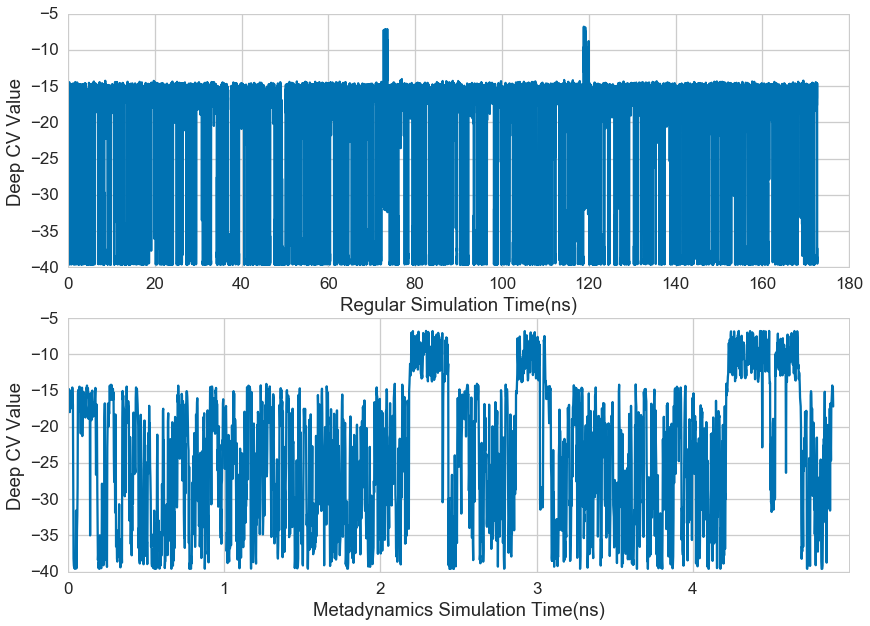

In [173]:
figure(figsize=(14,10))
subplot(2,1,1)
plot(new_y.data.tolist())
# msmbuilder ala sims are saved every ps
xticks([0,2000,4000,6000,8000,10000,12000,14000,16000,18000],[0,20,40,60,80,100,120,140,160,180])
ylim([-40,-5])
xlabel("Regular Simulation Time(ns)")
ylabel("Deep CV Value")

subplot(2,1,2)
plot(nn_y_plumed)
# our plumed sims are saved every 2ps 
xticks([0,500,1000,1500,2000],[0,1,2,3,4])
xlabel("Metadynamics Simulation Time(ns)")
ylabel("Deep CV Value")
ylim([-40,-5])


# Note that the x-axis is almost 36 times smaller than in the bottom panel. Thus we see 2x cross-overs in 1/36 the amount of simulations, making the overall simulation ~72x faster than regular sampling. 